# **DeepLearning Project** : DeepBach Study - *ANTOINE / PAQUIN*

Files for running this notebook are disponible on this github : 

 * https://github.com/paulpaq98/DeepBach-PP

## I- a) Imports :

In [2]:
import argparse
import os
import numpy 
import matplotlib.pyplot
import sys

import pickle
from music21 import *

from DeepBach.data_utils import part_to_inputs, initialization, BACH_DATASET, \
    pickled_dataset_path, SUBDIVISION
from DeepBach.model_manager import generation, load_models, train_models, \
    create_models
from metadata import *

/home/paquin-paul/.local/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Commentary : For the notebook to work some modifications had to be done
* Metadata.py and The notebook need to be in the same directory as DeepBach.py 
* line 5 : *"from .data_utils import SUBDIVISION"* ==> *"from DeepBach.data_utils import SUBDIVISION"*

## I - b) Code to Run : 

In [23]:
%matplotlib inline


def main():
   
   # parse arguments
    parser = argparse.ArgumentParser()
    parser.add_argument('--timesteps', help="model's range (default: %(default)s)",type=int, default=16)
    parser.add_argument('-b', '--batch_size_train',
                        help='batch size used during training phase (default: %(default)s)',type=int, default=128)
    parser.add_argument('-s', '--steps_per_epoch',help='number of steps per epoch (default: %(default)s)',type=int, default=500)
    parser.add_argument('--validation_steps',help='number of validation steps (default: %(default)s)',type=int, default=20)
    parser.add_argument('-u', '--num_units_lstm', nargs='+', help='number of lstm units (default: %(default)s)', type=int, default=[200, 200])
    parser.add_argument('-d', '--num_dense', help='size of non recurrent hidden layers (default: %(default)s)',
                        type=int, default=200)
    parser.add_argument('-n', '--name',
                        help='model name (default: %(default)s)',
                        choices=['deepbach', 'skip'],
                        type=str, default='deepbach')
    parser.add_argument('-i', '--num_iterations',
                        help='number of gibbs iterations (default: %(default)s)',
                        type=int, default=20000)
    parser.add_argument('-t', '--train', nargs='?',
                        help='train models for N epochs (default: 15)',
                        default=0, const=15, type=int)
    parser.add_argument('-p', '--parallel', nargs='?',
                        help='number of parallel updates (default: 16)',
                        type=int, const=16, default=1)
    parser.add_argument('--overwrite',
                        help='overwrite previously computed models',
                        action='store_true')
    parser.add_argument('-m', '--midi_file', nargs='?',
                        help='relative path to midi file',
                        type=str, const='datasets/god_save_the_queen.mid')
    parser.add_argument('-l', '--length',
                        help='length of unconstrained generation',
                        type=int, default=16)
    parser.add_argument('--ext',
                        help='extension of model name',
                        type=str, default='')
    parser.add_argument('-o', '--output_file', nargs='?',
                        help='path to output file',
                        type=str, default='',
                        const='generated_examples/example.mid')
    parser.add_argument('--dataset', nargs='?',
                        help='path to dataset folder',
                        type=str, default='')
    parser.add_argument('-r', '--reharmonization', nargs='?',
                        help='reharmonization of a melody from the corpus identified by its id',
                        type=int)
    parser.add_argument('-f', '--foo', nargs='?',
                        help='foo help')
    args = parser.parse_args()
 


    print(args)
    # fixed set of metadatas to use when CREATING the dataset
    # Available metadatas:
    # metadatas = [FermataMetadatas(), KeyMetadatas(window_size=1),
    # TickMetadatas(SUBDIVISION), ModeMetadatas()]
    metadatas = [TickMetadatas(SUBDIVISION), FermataMetadatas(),
                 KeyMetadatas(window_size=1)]

    if args.ext:
        ext = '_' + args.ext
    else:
        ext = ''

    # datasets
    # set pickled_dataset argument
    if args.dataset:
        dataset_path = args.dataset
        pickled_dataset = pickled_dataset_path(dataset_path)
        print('pickled_dataset', pickled_dataset)
    else:
        dataset_path = None
        pickled_dataset = BACH_DATASET
    if not os.path.exists(pickled_dataset):
        initialization(dataset_path, metadatas=metadatas, voice_ids=[0, 1, 2, 3])

    # load dataset
    print("loading dataset")
    X, X_metadatas, voice_ids, index2notes, note2indexes, metadatas = pickle.load(open(pickled_dataset,'rb'))
    NUM_VOICES = len(voice_ids)
    num_pitches = list(map(len, index2notes))
    timesteps = args.timesteps
    batch_size = args.batch_size_train
    steps_per_epoch = args.steps_per_epoch
    validation_steps = args.validation_steps
    num_units_lstm = args.num_units_lstm
    model_name = args.name.lower() + ext
    sequence_length = args.length
    batch_size_per_voice = args.parallel
    num_units_lstm = args.num_units_lstm
    num_dense = args.num_dense
    if args.output_file:
        output_file = args.output_file
    else:
        output_file = None

    # when reharmonization
    if args.midi_file:
        print("---- Harmonisation  ----")
        melody = converter.parse(args.midi_file)
        melody = part_to_inputs(melody.parts[0],length=sequence_length, index2note=index2notes[0], note2index=note2indexes[0])
        num_voices = NUM_VOICES - 1
        sequence_length = len(melody)
        # todo find a way to specify metadatas when reharmonizing a given melody
        chorale_metas = [metas.generate(sequence_length) for metas in metadatas]

    elif args.reharmonization:
        melody = X[args.reharmonization][0, :]
        num_voices = NUM_VOICES - 1
        chorale_metas = X_metadatas[args.reharmonization]
    else:
        num_voices = NUM_VOICES
        melody = None
        # todo find a better way to set metadatas

        # chorale_metas = [metas[:sequence_length] for metas in X_metadatas[11]]
        chorale_metas = [metas.generate(sequence_length) for metas in metadatas]

    num_iterations = args.num_iterations // batch_size_per_voice // num_voices
    parallel = batch_size_per_voice > 1
    train = args.train > 0
    num_epochs = args.train
    overwrite = args.overwrite
    print(model_name)
    if not os.path.exists('DeepBach/models/' + model_name + '_' + str(NUM_VOICES - 1) + '.yaml'):
        create_models(model_name, create_new=overwrite, num_units_lstm=num_units_lstm, num_dense=num_dense, pickled_dataset=pickled_dataset, num_voices=num_voices, metadatas=metadatas, timesteps=timesteps)
    if train:
        print(" --Start training models---")
        models = train_models(model_name=model_name, steps_per_epoch=steps_per_epoch, num_epochs=num_epochs, validation_steps=validation_steps, timesteps=timesteps, pickled_dataset=pickled_dataset, num_voices=NUM_VOICES, metadatas=metadatas, batch_size=batch_size)
    else:
        print(" --Loading models --")
        models = load_models(model_name, num_voices=NUM_VOICES)
    temperature = 1.
    timesteps = int(models[0].input[0]._keras_shape[1])
    print("--- Starting of the generation --- ")
    seq = generation(model_base_name=model_name, models=models, timesteps=timesteps, melody=melody, initial_seq=None, temperature=temperature, chorale_metas=chorale_metas, parallel=parallel, batch_size_per_voice=batch_size_per_voice, num_iterations=num_iterations, sequence_length=sequence_length, output_file=output_file, pickled_dataset=pickled_dataset)


if __name__ == '__main__':
    main()

Namespace(batch_size_train=128, dataset='', ext='', foo='/run/user/1000/jupyter/kernel-70aaf0b6-3d2d-4f3f-a608-010ccb0edb78.json', length=16, midi_file=None, name='deepbach', num_dense=200, num_iterations=20000, num_units_lstm=[200, 200], output_file='', overwrite=False, parallel=1, reharmonization=None, steps_per_epoch=500, timesteps=16, train=0, validation_steps=20)
loading dataset
deepbach
 --Loading models --
model /home/paquin-paul/Téléchargements/DeepBach-master-notebook2/DeepBach/models/deepbach_0 loaded
model /home/paquin-paul/Téléchargements/DeepBach-master-notebook2/DeepBach/models/deepbach_1 loaded
model /home/paquin-paul/Téléchargements/DeepBach-master-notebook2/DeepBach/models/deepbach_2 loaded



  0%|          | 0/5000 [00:00<?, ?it/s]

model /home/paquin-paul/Téléchargements/DeepBach-master-notebook2/DeepBach/models/deepbach_3 loaded
--- Starting of the generation --- 



 24%|██▎       | 1182/5000 [00:38<02:03, 30.88it/s]


 47%|████▋     | 2354/5000 [01:11<01:20, 32.87it/s]


 71%|███████   | 3538/5000 [01:44<00:43, 33.92it/s]


 94%|█████████▍| 4702/5000 [02:18<00:08, 33.95it/s]


100%|██████████| 5000/5000 [02:27<00:00, 33.97it/s]

SubConverterException: To create PNG files directly from MusicXML you need to download MuseScore and put a link to it in your .music21rc via Environment.

Commentary : For DeepBach to be able to run while using a jupyterNotebook there is a need to parse another argument. By parsing the argument "-f" or "-foo" Argparse is then able to run. The loading of datasets and models go smoothly as well as the generation but it seems there is trouble when trying to retreive the output. A musicXML path needs to be put in the .music21rc file, but doing does not seems to resolve the problem.

## II - Experimentation :

Arguments for a test :
* timesteps,
* batch_size_train,
* steps_per_epoch,
* validation_steps,
* num_units_lstm,
* num_dense
* name,
* num_iterations,
* train,
* parallel,
* midi_file,
* length,
* ext,
* output_file,
* dataset,
* reharmonization,

    
 

Here is a modified version of the main to make it easier to generate with customs models 

In [3]:
def main_exp(timesteps,
batch_size_train,
steps_per_epoch,
validation_steps,
num_units_lstm,
num_dense,
name,
num_iterations,
train,
parallel,
midi_file,
length,
ext,
output_file,
dataset):
   
   # parse arguments
    parser = argparse.ArgumentParser()
    parser.add_argument('--timesteps', help="model's range (default: %(default)s)",type=int, default=timesteps)
    parser.add_argument('-b', '--batch_size_train',
                        help='batch size used during training phase (default: %(default)s)',type=int, default=batch_size_train)
    parser.add_argument('-s', '--steps_per_epoch',help='number of steps per epoch (default: %(default)s)',type=int, default=steps_per_epoch)
    parser.add_argument('--validation_steps',help='number of validation steps (default: %(default)s)',type=int, default=validation_steps)
    parser.add_argument('-u', '--num_units_lstm', nargs='+', help='number of lstm units (default: %(default)s)', type=int, default=num_units_lstm)
    parser.add_argument('-d', '--num_dense', help='size of non recurrent hidden layers (default: %(default)s)',
                        type=int, default=num_dense)
    parser.add_argument('-n', '--name',
                        help='model name (default: %(default)s)',
                        choices=['deepbach', 'skip'],
                        type=str, default=name)
    parser.add_argument('-i', '--num_iterations',
                        help='number of gibbs iterations (default: %(default)s)',
                        type=int, default=num_iterations)
    parser.add_argument('-t', '--train', nargs='?',
                        help='train models for N epochs (default: 15)',
                        default=train, const=15, type=int)
    parser.add_argument('-p', '--parallel', nargs='?',
                        help='number of parallel updates (default: 16)',
                        type=int, const=16, default=parallel)
    parser.add_argument('--overwrite',
                        help='overwrite previously computed models',
                        action='store_true')
    parser.add_argument('-m', '--midi_file', nargs='?',
                        help='relative path to midi file',
                        type=str, const='datasets/god_save_the_queen.mid', default=midi_file)
    parser.add_argument('-l', '--length',
                        help='length of unconstrained generation',
                        type=int, default=length)
    parser.add_argument('--ext',
                        help='extension of model name',
                        type=str, default=ext)
    parser.add_argument('-o', '--output_file', nargs='?',
                        help='path to output file',
                        type=str, default=output_file,
                        const='generated_examples/example.mid')
    parser.add_argument('--dataset', nargs='?',
                        help='path to dataset folder',
                        type=str, default=dataset)
    parser.add_argument('-r', '--reharmonization', nargs='?',
                        help='reharmonization of a melody from the corpus identified by its id', default=reharmonization,
                        type=int)
    parser.add_argument('-f', '--foo', nargs='?',
                        help='foo help')
    args = parser.parse_args()
 


    print(args)
    # fixed set of metadatas to use when CREATING the dataset
    # Available metadatas:
    # metadatas = [FermataMetadatas(), KeyMetadatas(window_size=1),
    # TickMetadatas(SUBDIVISION), ModeMetadatas()]
    metadatas = [TickMetadatas(SUBDIVISION), FermataMetadatas(),
                 KeyMetadatas(window_size=1)]

    if args.ext:
        ext = '_' + args.ext
    else:
        ext = ''

    # datasets
    # set pickled_dataset argument
    if args.dataset:
        dataset_path = args.dataset
        pickled_dataset = pickled_dataset_path(dataset_path)
        print('pickled_dataset', pickled_dataset)
    else:
        dataset_path = None
        pickled_dataset = BACH_DATASET
    if not os.path.exists(pickled_dataset):
        initialization(dataset_path, metadatas=metadatas, voice_ids=[0, 1, 2, 3])

    # load dataset
    print("loading dataset")
    X, X_metadatas, voice_ids, index2notes, note2indexes, metadatas = pickle.load(open(pickled_dataset,'rb'))
    NUM_VOICES = len(voice_ids)
    num_pitches = list(map(len, index2notes))
    timesteps = args.timesteps
    batch_size = args.batch_size_train
    steps_per_epoch = args.steps_per_epoch
    validation_steps = args.validation_steps
    num_units_lstm = args.num_units_lstm
    model_name = args.name.lower() + ext
    sequence_length = args.length
    batch_size_per_voice = args.parallel
    num_units_lstm = args.num_units_lstm
    num_dense = args.num_dense
    if args.output_file:
        output_file = args.output_file
    else:
        output_file = None

    # when reharmonization
    if args.midi_file:
        print("---- Harmonisation  ----")
        melody = converter.parse(args.midi_file)
        melody = part_to_inputs(melody.parts[0],length=sequence_length, index2note=index2notes[0], note2index=note2indexes[0])
        num_voices = NUM_VOICES - 1
        sequence_length = len(melody)
        # todo find a way to specify metadatas when reharmonizing a given melody
        chorale_metas = [metas.generate(sequence_length) for metas in metadatas]

    elif args.reharmonization:
        melody = X[args.reharmonization][0, :]
        num_voices = NUM_VOICES - 1
        chorale_metas = X_metadatas[args.reharmonization]
    else:
        num_voices = NUM_VOICES
        melody = None
        # todo find a better way to set metadatas

        # chorale_metas = [metas[:sequence_length] for metas in X_metadatas[11]]
        chorale_metas = [metas.generate(sequence_length) for metas in metadatas]

    num_iterations = args.num_iterations // batch_size_per_voice // num_voices
    parallel = batch_size_per_voice > 1
    train = args.train > 0
    num_epochs = args.train
    overwrite = args.overwrite
    print(model_name)
    if not os.path.exists('DeepBach/models/' + model_name + '_' + str(NUM_VOICES - 1) + '.yaml'):
        create_models(model_name, create_new=overwrite, num_units_lstm=num_units_lstm, num_dense=num_dense, pickled_dataset=pickled_dataset, num_voices=num_voices, metadatas=metadatas, timesteps=timesteps)
    if train:
        print(" --Start training models---")
        models = train_models(model_name=model_name, steps_per_epoch=steps_per_epoch, num_epochs=num_epochs, validation_steps=validation_steps, timesteps=timesteps, pickled_dataset=pickled_dataset, num_voices=NUM_VOICES, metadatas=metadatas, batch_size=batch_size)
    else:
        print(" --Loading models --")
        models = load_models(model_name, num_voices=NUM_VOICES)
    temperature = 1.
    timesteps = int(models[0].input[0]._keras_shape[1])
    print("--- Starting of the generation --- ")
    seq = generation(model_base_name=model_name, models=models, timesteps=timesteps, melody=melody, initial_seq=None, temperature=temperature, chorale_metas=chorale_metas, parallel=parallel, batch_size_per_voice=batch_size_per_voice, num_iterations=num_iterations, sequence_length=sequence_length, output_file=output_file, pickled_dataset=pickled_dataset)
    

the below code launch the custom generation :

In [ ]:
if __name__ == '__main__':
    main_exp(timesteps,
batch_size_train,
steps_per_epoch,
validation_steps,
num_units_lstm,
num_dense,
name,
num_iterations,
train,
parallel,
midi_file,
length,
ext,
output_file,
dataset)

Namespace(batch_size_train=500, dataset='', ext='', foo='/run/user/1000/jupyter/kernel-0ce19824-5a94-43ee-9695-7b9604e135d5.json', length=160, midi_file='Source/05AnWasserflussen.mid', name='deepbach', num_dense=200, num_iterations=200000, num_units_lstm=[200, 200], output_file='Output/Generation/test_notebook_re.mid', overwrite=False, parallel=16, reharmonization=1, steps_per_epoch=200, timesteps=16, train=15, validation_steps=120)
loading dataset
---- Harmonisation  ----
deepbach
 --Start training models---
model /home/paquin-paul/Téléchargements/DeepBach-master-notebook2/DeepBach/models/deepbach_0 loaded


/home/paquin-paul/Téléchargements/DeepBach-master-notebook2/DeepBach/model_manager.py:764: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., steps_per_epoch=200, epochs=15, verbose=1, validation_data=<generator..., validation_steps=120)`
  validation_steps=validation_steps)


Epoch 1/15
122/200 [=================>............] - ETA: 1:46 - loss: 0.3689 - acc: 0.8903

In [4]:
timesteps = 16
batch_size_train = 500
steps_per_epoch = 200
validation_steps = 120
num_units_lstm = [200,200]
num_dense = 200
name = 'deepbach'
num_iterations = 200000
train = 15
parallel = 16
midi_file = 'Source/05AnWasserflussen.mid'
length = 160
ext = ''
output_file = 'Output/Generation/test_notebook_re.mid'
dataset =''
reharmonization = 1

Here are the base parameters : 

In [46]:
main_exp(16,
128,
500,
200,
[200,200],
200,
'deepbach',
20000,
0,
1,
'',
160,
'',
'',
'')

Namespace(batch_size_train=128, dataset='', ext='', foo='/run/user/1000/jupyter/kernel-0ce19824-5a94-43ee-9695-7b9604e135d5.json', length=160, midi_file='', name='deepbach', num_dense=200, num_iterations=20000, num_units_lstm=[200, 200], output_file='', overwrite=False, parallel=1, reharmonization=1, steps_per_epoch=500, timesteps=16, train=0, validation_steps=200)
loading dataset
deepbach
 --Loading models --
model /home/paquin-paul/Téléchargements/DeepBach-master-notebook2/DeepBach/models/deepbach_0 loaded
model /home/paquin-paul/Téléchargements/DeepBach-master-notebook2/DeepBach/models/deepbach_1 loaded
model /home/paquin-paul/Téléchargements/DeepBach-master-notebook2/DeepBach/models/deepbach_2 loaded



  0%|          | 0/6666 [00:00<?, ?it/s]

model /home/paquin-paul/Téléchargements/DeepBach-master-notebook2/DeepBach/models/deepbach_3 loaded
--- Starting of the generation --- 



  9%|▉         | 601/6666 [00:18<03:09, 32.07it/s]


 18%|█▊        | 1226/6666 [00:35<02:37, 34.51it/s]


 28%|██▊       | 1839/6666 [00:52<02:18, 34.85it/s]


 37%|███▋      | 2453/6666 [01:10<02:00, 34.98it/s]


 46%|████▋     | 3092/6666 [01:27<01:40, 35.52it/s]


 55%|█████▌    | 3672/6666 [01:45<01:25, 34.96it/s]


 65%|██████▌   | 4338/6666 [02:02<01:05, 35.37it/s]


 74%|███████▍  | 4938/6666 [02:20<00:49, 35.19it/s]


 83%|████████▎ | 5504/6666 [02:38<00:33, 34.79it/s]


 91%|█████████ | 6081/6666 [02:56<00:16, 34.46it/s]


100%|█████████▉| 6635/6666 [03:15<00:00, 34.02it/s]


100%|██████████| 6666/6666 [03:15<00:00, 34.02it/s]

SubConverterException: To create PNG files directly from MusicXML you need to download MuseScore and put a link to it in your .music21rc via Environment.

Custom models can explicit certain dataset, the path is therefore linked to the file organization on the user's computer. If this argument is not given the dataset can be generated (~1hour) or a already created dataset (data_bach.pickle) can be used. This last dataset can be extracted from the archive "download_pretrained_data.sh"

# Generation of a score

We re-trained the base model for 5, 10 and 15 epochs. The architecture we used is similar to the base one using a [200,200] neural network for the LSTMs and a 200 neurons layer for the dense network.

We obtained -via Musescore- scores like this one ; 

In [73]:
from IPython.display import Image

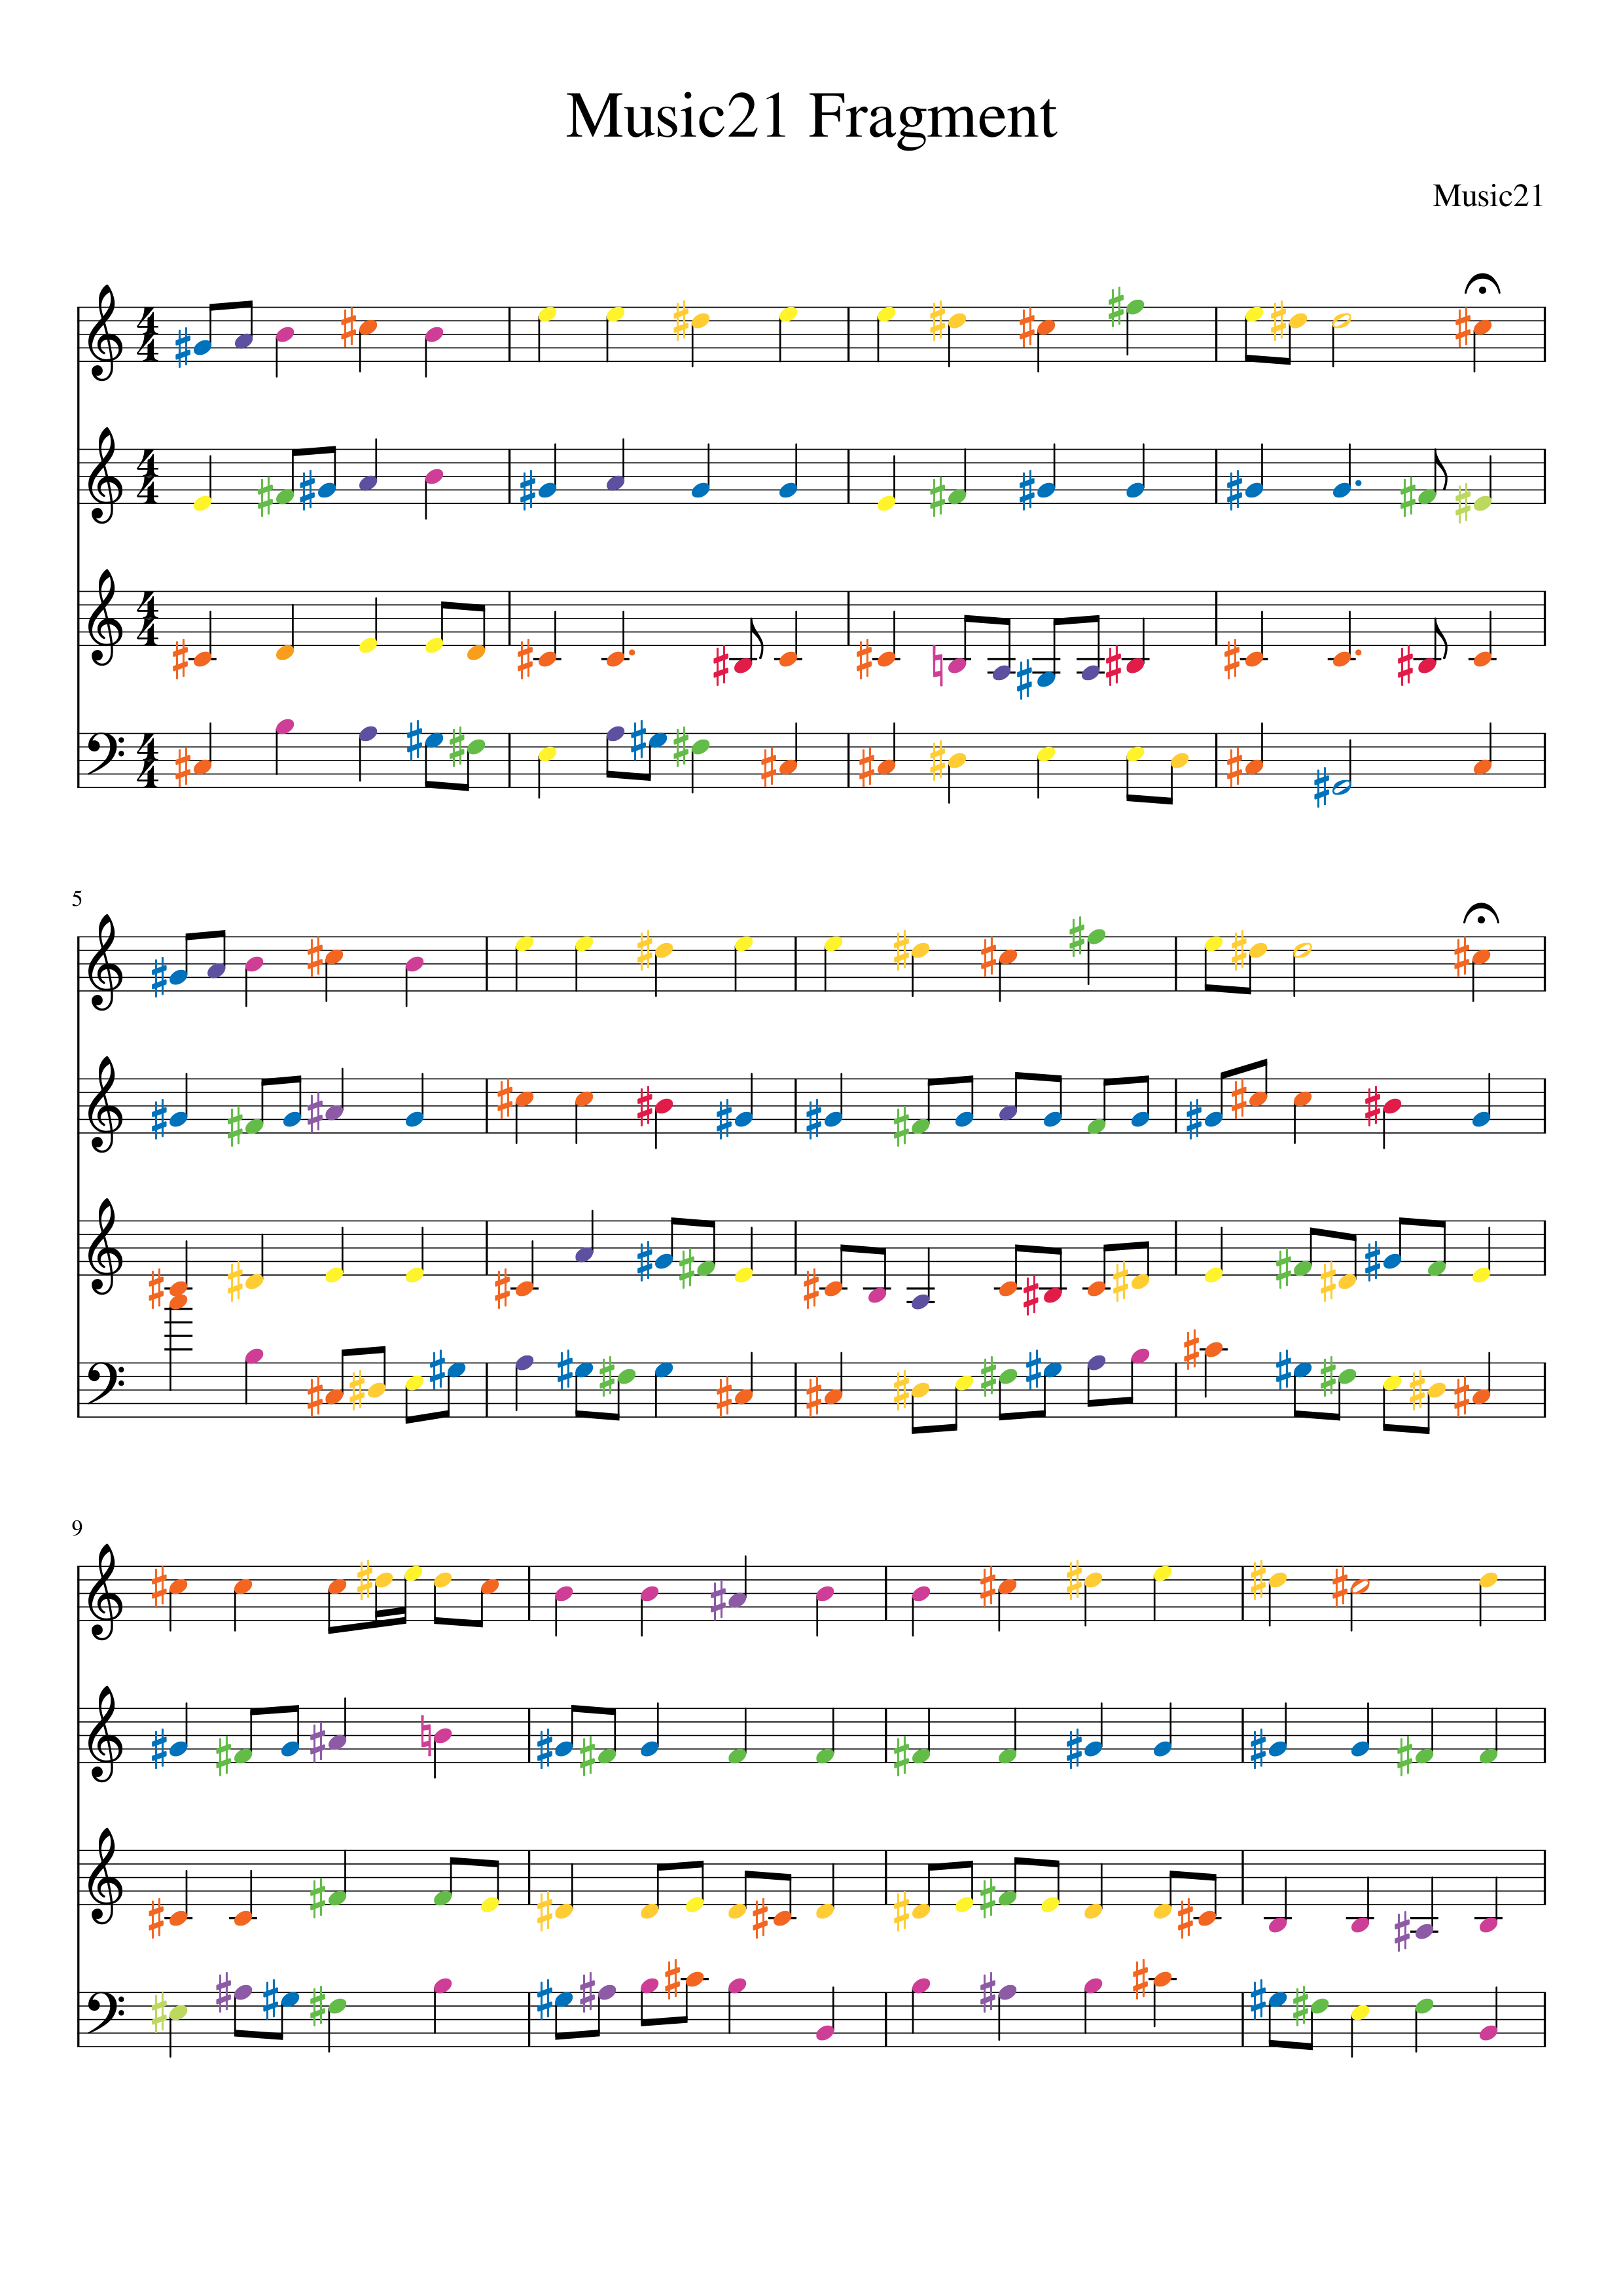

In [76]:
Image("Output/Partition/pretrained_base_3_i-1.png")

Here is an example of music generation played thanks to the pygame module :

(the path to the files should be updated in order for the script to work) 

In [117]:
# play .mid music files using PyGame on your computer's sound card
# PyGame is free from: http://www.pygame.org/news.html
# tested with Python25 and PyGame171      vegaseat     27aug2007
import pygame
def play_music(music_file):
    """
    stream music with mixer.music module in blocking manner
    this will stream the sound from disk while playing
    """
    clock = pygame.time.Clock()
    try:
        pygame.mixer.music.load(music_file)
        print("Music file %s loaded!" % music_file)
    except pygame.error:
        print("File %s not found! (%s)" % (music_file, pygame.get_error()))
        return
    pygame.mixer.music.play()
    while pygame.mixer.music.get_busy():
        # check if playback has finished
        clock.tick(30)

In [131]:
# pick a midi music file you have ...
# (if not in working folder use full path)
music_file = "Output/Generation/pretrained_base_3_i.mp3"
freq = 44100    # audio CD quality
bitsize = -16   # unsigned 16 bit
channels = 2    # 1 is mono, 2 is stereo
buffer = 1024    # number of samples
pygame.mixer.init(freq, bitsize, channels, buffer)
# optional volume 0 to 1.0
pygame.mixer.music.set_volume(0.8)
try:
    play_music(music_file)
except KeyboardInterrupt:
    # if user hits Ctrl/C then exit
    # (works only in console mode)
    pygame.mixer.music.fadeout(1000)
    pygame.mixer.music.stop()
raise SystemExit

Music file Output/Generation/pretrained_base_3_i.mp3 loaded!


SystemExit: 

/home/paquin-paul/.local/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2971: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


# Reharmonization of a generated tune

(Again the path must be updated)

Let's see the impact of the number of epochs used to train the neural network upon the output.
Here the input is always the same, a generated tune using a deepbach model using 15 epochs to train itself.

In [140]:
reference = "Output/Comparisons/An_Wasserflussen_Babylon/AnWasserflussenBabylon.mp3"
reference_5 = "Output/Comparisons/An_Wasserflussen_Babylon/AnWasserflussenBabylon_t5_i10000.mp3"
reference_10 = "Output/Comparisons/An_Wasserflussen_Babylon/AnWasserflussenBabylon_t15_i10000.mp3"
reference_25 = "Output/Comparisons/An_Wasserflussen_Babylon/AnWasserflussenBabylon_t25_i10000.mp3"

Reference :

In [141]:
try:
    play_music(reference)
except KeyboardInterrupt:
    # if user hits Ctrl/C then exit
    # (works only in console mode)
    pygame.mixer.music.fadeout(1000)
    pygame.mixer.music.stop()
raise SystemExit

Music file Output/Comparisons/An_Wasserflussen_Babylon/AnWasserflussenBabylon.mp3 loaded!


SystemExit: 

/home/paquin-paul/.local/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2971: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


5 epochs :

In [134]:
try:
    play_music(reference_5)
except KeyboardInterrupt:
    # if user hits Ctrl/C then exit
    # (works only in console mode)
    pygame.mixer.music.fadeout(1000)
    pygame.mixer.music.stop()
raise SystemExit

Music file Output/Comparisons/Generated_reference/reference_t5_i10000.mp3 loaded!


SystemExit: 

/home/paquin-paul/.local/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2971: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


15 epochs :

In [135]:
try:
    play_music(reference_15)
except KeyboardInterrupt:
    # if user hits Ctrl/C then exit
    # (works only in console mode)
    pygame.mixer.music.fadeout(1000)
    pygame.mixer.music.stop()
raise SystemExit

Music file Output/Comparisons/Generated_reference/reference_t25_i10000.mp3 loaded!


SystemExit: 

/home/paquin-paul/.local/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2971: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


25 epochs :

In [139]:
try:
    play_music(reference_25)
except KeyboardInterrupt:
    # if user hits Ctrl/C then exit
    # (works only in console mode)
    pygame.mixer.music.fadeout(1000)
    pygame.mixer.music.stop()
raise SystemExit

Music file Output/Comparisons/Generated_reference/reference_t25_i10000.mp3 loaded!


SystemExit: 

/home/paquin-paul/.local/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2971: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
